In [3]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
plt.style.use('ggplot')

# Create a BigQuery client
client = bigquery.Client.from_service_account_json("key.json")

In [2]:
class Stock:
    query = """
SELECT * FROM `cse-6242-fa24-lz.stock_prices_data.stock_price_history`
"""
    stock_raw = (client.query(query)
                        .to_dataframe()
                        .sort_values(by='date')
                        .reset_index(drop=True))
class StockSel(Stock):
    def __init__(self,ticker):
        self.ticker = ticker
        self.col_name = '_close_{}x'.format(ticker)
        assert self.col_name in self.stock_raw.columns, "ticker not found"
        self.stock_sel = self.stock_raw[['date', self.col_name]]
        self.get_active_month_close()
        self.get_inactive_avg()
        self.get_rel_monthly_close()
        self.get_active_week_close()
        self.get_rel_weekly_close()
    def get_active_month_close(self):
        # get the close value on the last available day of each month
        self.active_month_close = self.stock_sel.groupby([self.stock_sel['date'].dt.year, self.stock_sel['date'].dt.month]).tail(1)
        self.active_month_close = self.active_month_close[self.active_month_close['date'].dt.month.isin(range(6, 12))].reset_index(drop=True)
    def get_active_week_close(self):
        # Filter the data to include only dates from June to November
        self.active_week_close = self.stock_sel[
            self.stock_sel['date'].dt.month.isin(range(6, 12))
        ].copy()

        # Set the date as the index for resampling
        self.active_week_close.set_index('date', inplace=True)

        # Resample by week and take the last available close price for each week
        self.active_week_close = (
            self.active_week_close.resample('W').last().reset_index()
        )
        
        # Reset index for convenience
        self.active_week_close.reset_index(drop=True, inplace=True)
    def get_inactive_avg(self):
        # get the average stock price from days in inactive months
        self.inactive_months = self.stock_sel[~self.stock_sel['date'].dt.month.isin(range(6, 12))]
        self.inactive_months['year'] = self.inactive_months['date'].dt.year
        self.inactive_year_avg = (self.inactive_months.groupby('year')[self.col_name]
                                                    .mean()
                                                    .reset_index())
    def get_rel_monthly_close(self):
        # get the reletive stock price
        self.active_month_close['year'] = self.active_month_close['date'].dt.year
        self.stock_month_merged = self.active_month_close.merge(
                        self.inactive_year_avg,
                        on = 'year', suffixes=('','_yr')
                        )
        self.stock_month_merged['rel_close'] = self.stock_month_merged[self.col_name] / \
                                                        self.stock_month_merged[self.col_name+'_yr']
        self.rel_stock_monthly = self.stock_month_merged[['date','rel_close']]
    def get_rel_weekly_close(self):
        # get the reletive stock price
        self.active_week_close['year'] = self.active_week_close['date'].dt.year
        self.stock_week_merged = self.active_week_close.merge(
                        self.inactive_year_avg,
                        on = 'year', suffixes=('','_yr')
                        )
        self.stock_week_merged['rel_close'] = self.stock_week_merged[self.col_name] / \
                                                        self.stock_week_merged[self.col_name+'_yr']
        self.rel_stock_weekly = self.stock_week_merged[['date','rel_close']]
        

/home/chen112p/.pyenv/versions/3.12.4/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [151]:
home_depot = StockSel(ticker='hd')
lowes = StockSel(ticker='low')
spy = StockSel(ticker='spy')

/tmp/ipykernel_353653/4082327771.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.inactive_months['year'] = self.inactive_months['date'].dt.year
/tmp/ipykernel_353653/4082327771.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.inactive_months['year'] = self.inactive_months['date'].dt.year
/tmp/ipykernel_353653/4082327771.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [120]:
home_depot.rel_stock_weekly

,date,rel_close
0,2014-10-26 00:00:00+00:00,0.941228
1,2014-11-02 00:00:00+00:00,0.966297
2,2014-11-09 00:00:00+00:00,0.967585
3,2014-11-16 00:00:00+00:00,0.973431
4,2014-11-23 00:00:00+00:00,0.973828
...,...,...
518,2024-09-29 00:00:00+00:00,1.124834
519,2024-10-06 00:00:00+00:00,1.149694
520,2024-10-13 00:00:00+00:00,1.159660
521,2024-10-20 00:00:00+00:00,1.168388


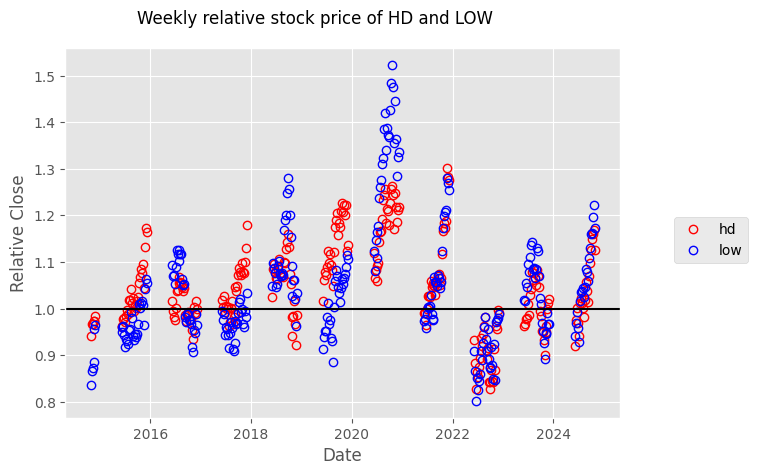

In [145]:
color_list = ['r','b','m','g']
obj_list = [home_depot,
            lowes,
            ]
f,ax = plt.subplots(1,1)
for i,obj in enumerate(obj_list):
    ax.plot(obj.rel_stock_weekly['date'], 
                obj.rel_stock_weekly['rel_close'], 
                '{}o'.format(color_list[i]), mfc='none',label=obj.ticker)

ax.axhline(y=1,color='k')
ax.set_xlabel('Date')
ax.set_ylabel('Relative Close')

f.suptitle('Weekly relative stock price of HD and LOW')
f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
f.tight_layout()


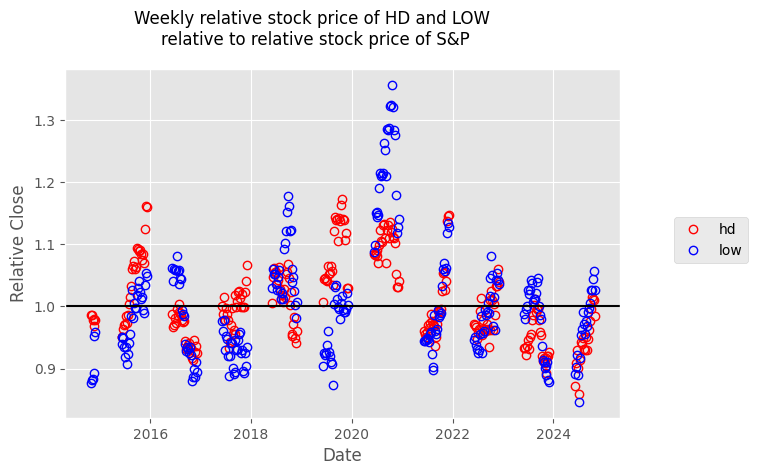

In [146]:
color_list = ['r','b','m','g']
obj_list = [home_depot,
            lowes,
            ]
f,ax = plt.subplots(1,1)
for i,obj in enumerate(obj_list):
    ax.plot(obj.rel_stock_weekly['date'], 
                obj.rel_stock_weekly['rel_close'] / spy.rel_stock_weekly['rel_close'], 
                '{}o'.format(color_list[i]), mfc='none',label=obj.ticker)

ax.axhline(y=1,color='k')
ax.set_xlabel('Date')
ax.set_ylabel('Relative Close')

f.suptitle('Weekly relative stock price of HD and LOW \nrelative to relative stock price of S&P')
f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
f.tight_layout()